In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
l=20
u=5
shift_hours=8
np.random.seed(1)

In [ ]:
def simulate_queue(s):
  """
  simulate an M/M/s queue over 'shift_hours'
  returns arrays of wait times and system sizes at arrivals
  """
  inter =np.random.exponential(1/l,int(l*shift_hours*1.5))
  arrivals =np.cumsum(inter)
  arrivals=arrivals[arrivals< shift_hours]
  N=len(arrivals)
  services =np.random.exponential(1/u ,N)
  next_free=np.zeros(s)
  wait_times=np.zeros(N)
  system_size=np.zeros(N)
  dep_times=[]
  for i,t in enumerate (arrivals):
    j=np.argmin(next_free)
    start =max(t,np.min(next_free))
    wait_times[i]=start -t
    end =start + services[i]
    next_free[j]=end
    dep_times.append(end)
    system_size[i]=np.sum(np.array(dep_times)>t)
  return  wait_times,system_size

w1, q1 =simulate_queue(s=1)
print(f"s=1: avg wait { w1.mean()*60:.1f} mins, avg queue len{q1.mean():.2f}")



s=1: avg wait 808.2 mins, avg queue len65.99


In [ ]:
p1=l/u
L_analytic =p1 /(1-p1)
W_analytic =L_analytic/l
print("M/M/1 analytic vs simulation:")
print(f"Analytic system size: {L_analytic:.2f}")
print(f"simulated system size: {q1.mean():.2f}")
print(f"Analytic wait time: {W_analytic*60:.1f} mins")
print(f"simulated wait time: {w1.mean()*60+(1/u)*60:.1f} mins")


M/M/1 analytic vs simulation:
Analytic system size: -1.33
simulated system size: 65.99
Analytic wait time: -4.0 mins
simulated wait time: 820.2 mins


In [ ]:
#4. Test staffing levels(s=1..5)
threshold = 5 #minutes
results =[]

for s in range(1,6):
  w,q = simulate_queue(s)
  waits_min = w*60
  p95_wait = np.percentile(waits_min, 95)
  results.append((s,waits_min.mean(),p95_wait,q.mean()))

# tabulate
import pandas as pd
df = pd.DataFrame(results, columns=["Agents","avg_wait(min)","95th-pct wait (min)","Avg Syste Size"])
print(df)

#find minimal s meeting threshold

good = df[df['95th-pct wait (min)'] <= threshold]
if not good.empty:
  best_s = int(good.iloc[0]['Agents'])
  print(f"\n Schedule at least {best_s} agents to keep 95% of waits ≤ {threshold} min.")
else:
  print("\nEven 5 agents can't meet the 5 min 95% wait target.")

   Agents  avg_wait(min)  95th-pct wait (min)  Avg Syste Size
0       1     967.452943          1793.756738       79.601990
1       2     284.779188           439.788565       50.137500
2       3      40.007276            82.949132       14.273333
3       4      30.237601            48.142521       15.094675
4       5       5.135539            20.229423        6.611765

Even 5 agents can't meet the 5 min 95% wait target.


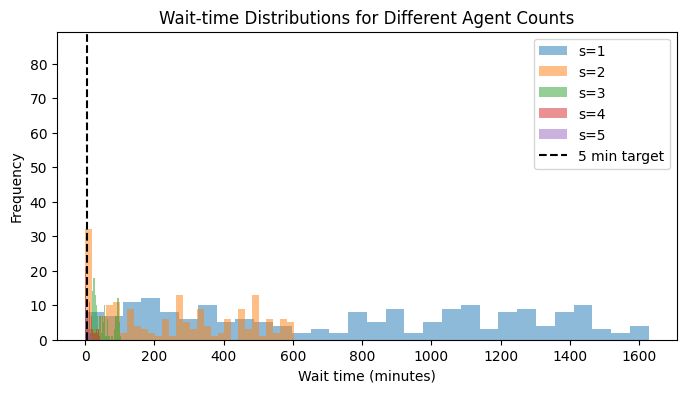

In [ ]:


plt.figure(figsize=(8,4))
for s in [1,2,3,4,5]:
    w, _ = simulate_queue(s)
    plt.hist(w*60, bins=30, alpha=0.5, label=f's={s}')
plt.axvline(threshold, color='k', linestyle='--', label='5 min target')
plt.xlabel('Wait time (minutes)')
plt.ylabel('Frequency')
plt.title('Wait-time Distributions for Different Agent Counts')
plt.legend()
plt.show()

In [ ]:
def simulate_queue_timevarying(s):
  periods =[(0,2,30),(2,6,20),(6,8,40)]
  arrivals =[]
  for start ,end ,lam in periods :
    duration=end -start
    inter =np.random.exponential(1/lam,int(lam*duration*1.5))
    ts =np.cumsum(inter) +start
    arrivals.extend(ts[ts <end])
  arrivals =np.array(arrivals)
  arrivals.sort()
  N=len(arrivals)
  services =np.random.exponential(1/u,N)
  next_free=np.zeros(s)
  wait_times=np.zeros(N)

  for i,t in enumerate(arrivals):
    j=np.argmin(next_free)
    start =max(t,np.min(next_free))
    wait_times[i]=start -t

    next_free[j]=start +services[i]
  return wait_times

w_tv=simulate_queue_timevarying(s=3)
print(f"s=1: avg wait {w_tv.mean()*60:.1f} min")

s=1: avg wait 84.5 min


In [ ]:
# 7. Abandonment
def simulate_with_abandon(s, patience=5/60):
    arrivals = np.cumsum(np.random.exponential(1/l, int(l*shift_hours*1.5)))
    arrivals = arrivals[arrivals < shift_hours]
    services = np.random.exponential(1/u, len(arrivals))
    next_free = np.zeros(s)
    waits = []
    abandons = 0

    for i, t in enumerate(arrivals):
        j = np.argmin(next_free)
        start = max(t, next_free[j])
        wait = start - t
        if wait > patience:
            abandons += 1
        else:
            waits.append(wait)
            next_free[j]=start + services[i]
    return np.array(waits), abandons/len(arrivals)

w, ab_rate = simulate_with_abandon(s=4)
print(f"Abandon rate (s=4): {ab_rate:.2%}, avg wait on served calls: {w.mean()*60:.1f} min")

Abandon rate (s=4): 23.60%, avg wait on served calls: 0.9 min


In [ ]:
def simulate_with_breaks(s, break_start=3, break_length=0.25):
    arrivals = np.cumsum(np.random.exponential(1/l, int(l*shift_hours*1.5)))
    arrivals = arrivals[arrivals < shift_hours]
    services = np.random.exponential(1/u, len(arrivals))
    next_free = np.zeros(s)
    waits = []

    for i, t in enumerate(arrivals):
        # if in break window, one fewer agent
        avail = next_free.copy()
        if break_start < t < break_start + break_length:
            avail = np.delete(avail, 0)  # remove one agent
        j = np.argmin(avail)
        start = max(t, avail[j])
        waits.append(start - t)
        # update that agent's free time in original array
        idx = j + (1 if break_start < t < break_start + break_length else 0)
        next_free[idx] = start + services[i]

    return np.array(waits)

w_b = simulate_with_breaks(s=3)
print(f"With breaks, s=3 -> avg wait = {w_b.mean()*60:.1f} min")

With breaks, s=3 -> avg wait = 186.0 min


In [ ]:
# Cost optimization
c_agent = 20  # $20/hr per agent
c_wait = 0.50  # $0.50 per minute waited

costs = []
for s in range(1, 6):
    w, ab_rate = simulate_with_abandon(s)  # unpack the tuple
    total_wait_cost = w.sum()*60*c_wait
    staff_cost = s * c_agent * shift_hours
    costs.append((s, staff_cost + total_wait_cost))

opt = min(costs, key=lambda x: x[1])
print("Agent count, total cost:")
for s, c in costs:
    print(f" s={s}: ${c:,.0f}")
print(f"Optimal s by cost = {opt[0]}")

Agent count, total cost:
 s=1: $191
 s=2: $367
 s=3: $563
 s=4: $731
 s=5: $839
Optimal s by cost = 1


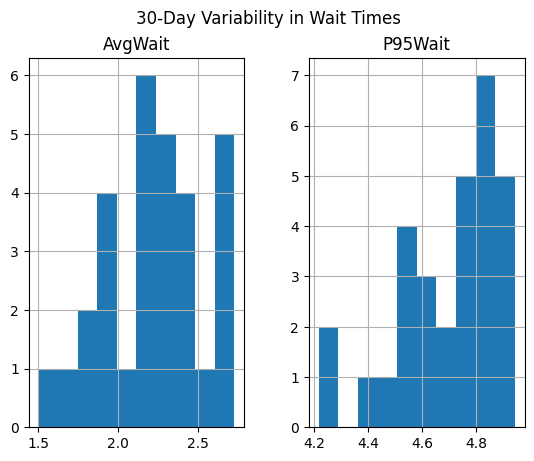

In [ ]:
# 10. 30-day simulation
days = 30
daily = []
for _ in range(days):
    w, _ = simulate_with_abandon(opt[0])
    daily.append((w.mean() * 60, np.percentile(w * 60, 95)))

df_days = pd.DataFrame(daily, columns=['AvgWait', 'P95Wait'])
df_days.describe()
df_days.hist(bins=10)
plt.suptitle('30-Day Variability in Wait Times')
plt.show()